In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_scoredf_true["Type 1"].value_counts()

In [2]:
#Reading the file 
df = pd.read_csv('data/Pokemon.csv')
df.shape

(634, 12)

In [3]:
#checking for duplicates
df.drop_duplicates()
df.shape

(634, 12)

In [4]:
# preview the data
df.head(10)

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Chikorita,Grass,NaN,318,45,49,65,49,65,45,2,False
1,Bayleef,Grass,NaN,405,60,62,80,63,80,60,2,False
2,Meganium,Grass,NaN,525,80,82,100,83,100,80,2,False
3,Cyndaquil,Fire,NaN,309,39,52,43,60,50,65,2,False
4,Quilava,Fire,NaN,405,58,64,58,80,65,80,2,False
5,Typhlosion,Fire,NaN,534,78,84,78,109,85,100,2,False
6,Totodile,Water,NaN,314,50,65,64,44,48,43,2,False
7,Croconaw,Water,NaN,405,65,80,80,59,63,58,2,False
8,Feraligatr,Water,NaN,530,85,105,100,79,83,78,2,False
9,Sentret,Normal,NaN,215,35,46,34,35,45,20,2,False


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

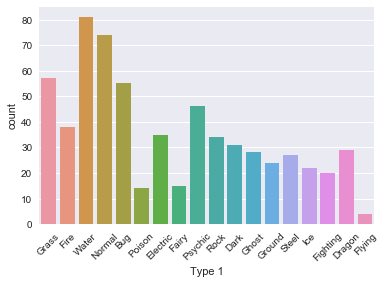

In [5]:
# Type 1 varibale distribution
sns.countplot(x="Type 1", data=df)
plt.xticks(rotation=45)

In [6]:
# looking at missing values in all the variables
df.apply(lambda x: sum(x.isnull()),axis=0) 

Name            0
Type 1          0
Type 2        298
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

The only missing values in the pokemon dataset are those in the column Type 2. Let us look at the proportion of pokemon that have dual types vs single type.

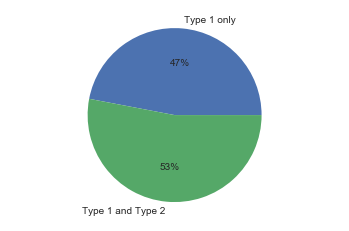

In [7]:
proportion_of_Type_2 = [df['Type 1'].count() - df['Type 2'].count(),df['Type 2'].count()]
plt.axis('equal');
plt.pie(proportion_of_Type_2, autopct='%1.0f%%', labels=['Type 1 only', 'Type 1 and Type 2']);

Since 47% of pokemons has only Type 1, instead of dropping those data samples, I will replace null values in Type 2 with "None". I will look at "None" as a category for Type 2. Another approach for this problem is to duplicate those data samples which have both type 1 and type 2 and drop the category type 2 completely thereafter. This results in an increase of data size but leads to the introduction of a lot of noise since I am assigning the same data point to multiple clusters. I tested this approach and concluded that it was not useful for this problem and therefore it has not been shown in this notebook.

In [8]:
# Treating missing values as a separate category
df['Type 2'].fillna('None',inplace=True)

In [9]:
# Numerical and One-Hot Coding of Categorical variables
var_mod = ['Type 1','Type 2']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
# One Hot Coding:
df = pd.get_dummies(df, columns=['Type 2','Generation'])

Let us look at the proportion of Legendary Pokemons in the dataset.

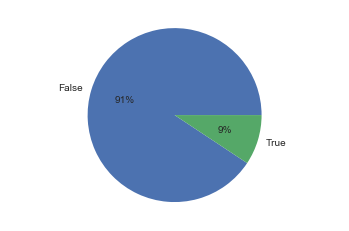

In [10]:
proportion_of_legendary = df["Name"].groupby(df["Legendary"]).count()
plt.axis('equal');
plt.pie(proportion_of_legendary, autopct='%1.0f%%', labels=proportion_of_legendary.index);

How different are the Legendary Pokemons from the normal ones? Let us compare the distribution of different features for Legendary and Non-Legendary Pokemons. In the following figures, the blue curve is the distribution for Non-Legendary Pokemon and the green is the distribution for Legendary pokemons. Clearly, there is a stark difference and the distribution is very different for these two different kind of pokemons.

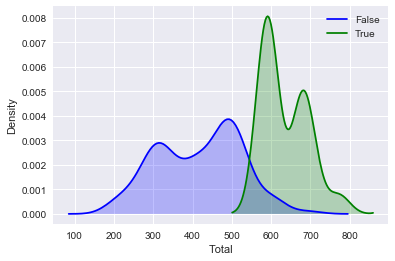

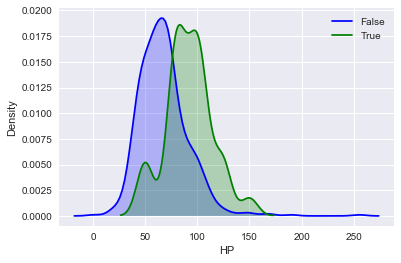

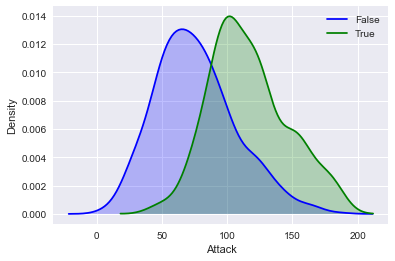

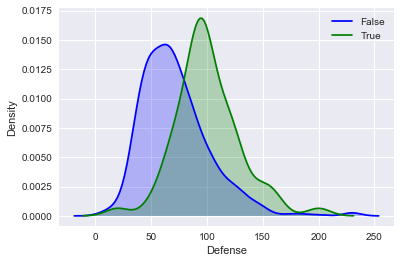

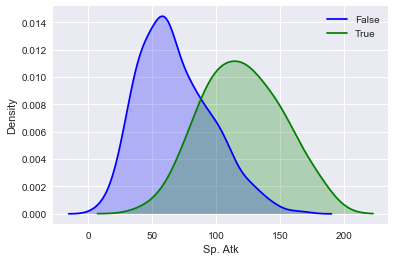

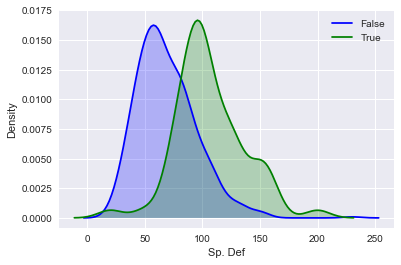

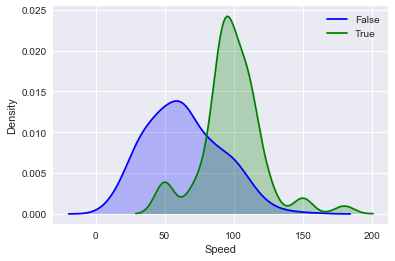

In [11]:
var_mod=["Total", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
for var in var_mod:
    plt.figure()
    plt.xlabel(var)
    plt.ylabel("Density")
    sns.kdeplot(df[df["Legendary"]==False][var], label="False", color='blue', shade="True")
    sns.kdeplot(df[df["Legendary"]==True][var], label="True", color='green', shade="True")

From the above distributions, we can conclude that it is better to treat the Legendary Pokemons separate from the non-legendary pokemons. Next, I will create two separate models for prediction: One for the Legendary pokemons and the other one for the non-legendary pokemons.

In [12]:
#df_false contains normal pokemons and df_true contains Legendary pokemons
df_false=df[df["Legendary"]==False]
df_false=df_false.drop(["Legendary"], axis=1)
df_true=df[df["Legendary"]==True]
df_true=df_true.drop(["Legendary"], axis=1)

Now I will develop a model for non-legendary pokemons i.e pokemons which have Legendary=False

# Outlier detection

Next, I will try to find and remove outliers from the data. As a rule, for each feature I will calculate the mean $\mu$ and the variance $\sigma^{2}$ and plot the number of data samples that lies within $\mu \pm k\sigma$ with $k$. This is a non-decreasing graph and it is possible to see an elbow shape in the graph. For every feature I found that that the data is widely spread and therefore as a heuristic, I decided to tag those data sample which are outside $[\mu+3\sigma,\mu-3\sigma]$ to be outliers. I iterated through every feature and removed those outliers. 

I am defining two functions below - outlier_detection and outlier_removal. 

In [13]:
def outlier_detection(feature, data):
    f = {'Mean':['mean'], 'Variance':['var']}
    variance_list=[]
    mean_list=[]
    outlier_detection = data.groupby('Type 1', as_index=False)[feature].agg(f)
    for label in range(0, 18):
        (variance, mean)=(outlier_detection.ix[label][1],outlier_detection.ix[label][2])
        variance_list.append(variance)
        mean_list.append(mean)
        number_of_points=[]
        for i in range(1,11):
            number_of_points.append(len(data[(data[feature] >= (mean-(i*np.sqrt(variance)))) & (data[feature] <= (mean+(i*np.sqrt(variance)))) & (data['Type 1']==label)]))
        x=np.arange(1,11)
        plt.xlabel("k")
        plt.ylabel("number of data samples")
        plt.plot(x, number_of_points)
    return (mean_list, variance_list)

In [14]:
def outlier_removal(feature, data, factor, mean_list, variance_list):
    for label in range(0, 18):
        data=data[((data[feature] >= (mean_list[label]-(factor*np.sqrt(variance_list[label])))) & (data[feature] <= (mean_list[label]+(factor*np.sqrt(variance_list[label]))))& (data['Type 1']==label))|(data['Type 1']!=label)]
    return data

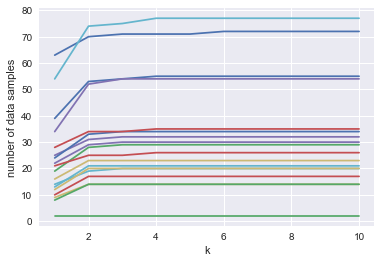

In [15]:
(mean_list, variance_list)=outlier_detection('HP', df_false)

In [16]:
df_false=outlier_removal('HP', df_false, 3, mean_list, variance_list)

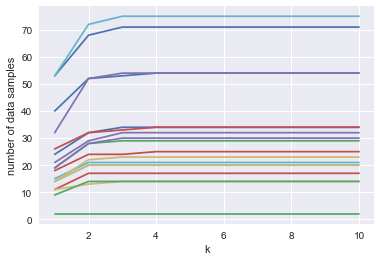

In [17]:
(mean_list, variance_list)=outlier_detection('Attack', df_false)

In [18]:
df_false=outlier_removal('Attack', df_false, 3, mean_list, variance_list)

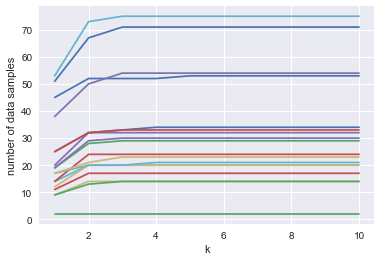

In [19]:
(mean_list, variance_list)=outlier_detection('Defense', df_false)

In [20]:
df_false=outlier_removal('Defense', df_false, 3, mean_list, variance_list)

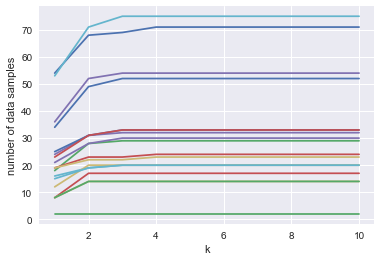

In [21]:
(mean_list, variance_list)=outlier_detection('Sp. Atk', df_false)

In [22]:
df_false=outlier_removal('Sp. Atk', df_false, 3, mean_list, variance_list)

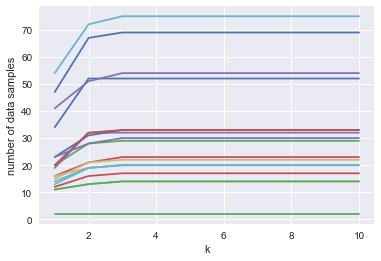

In [23]:
(mean_list, variance_list)=outlier_detection('Sp. Def', df_false)

In [24]:
df_false=outlier_removal('Sp. Def', df_false, 3, mean_list, variance_list)

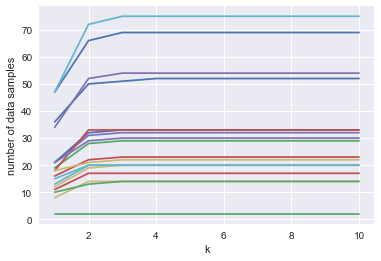

In [25]:
(mean_list, variance_list)=outlier_detection('Speed', df_false)

In [26]:
df_false=outlier_removal('Speed', df_false, 3, mean_list, variance_list)

Next, let us look at the correlation between different attributes using a heatmap.

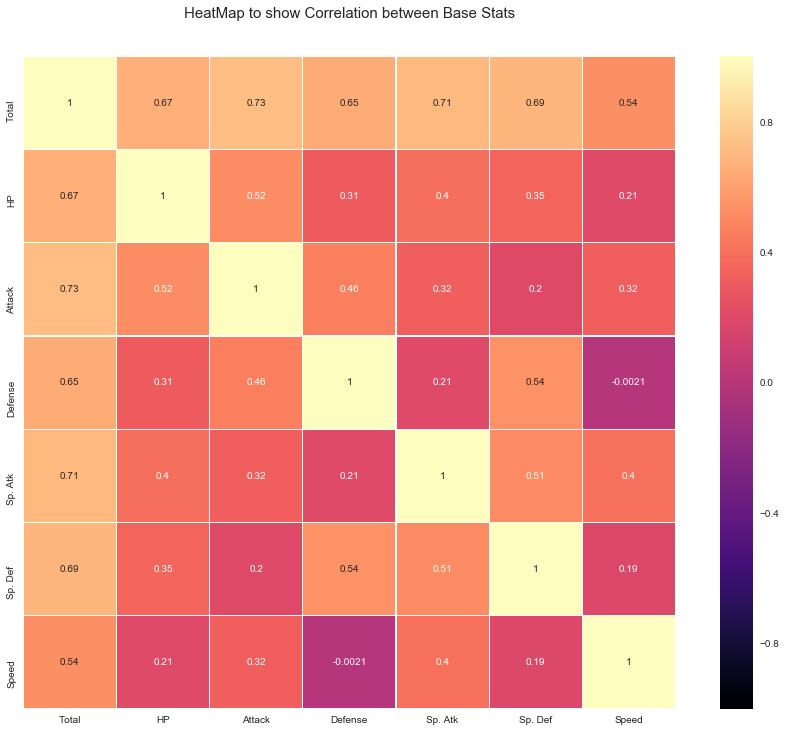

In [27]:
Corr = df_false[['Total' ,'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
colormap = plt.cm.magma
plt.figure(figsize=(16,12))
plt.title('HeatMap to show Correlation between Base Stats', y=1.05, size=15)
sns.heatmap(Corr.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

It can be noticed that only the feature "Total" has a high correlation with every other feature. This is not surprising since the "Total" feature is just the sum of the all the other numerical features. Therefore this feature is redundant for a linear model and hence it is dropped.

I am now ready to create my base model. For this, I will define two functions - classification() and evaluation(). I split the dataset into train and test datasets using stratified random sampling in the ratio of 8:2. The best parameters in each case are chosen by cross-validation over the training data (this is not shown in this notebook). I am training the appropriate model using train dataset and then making predictions on the test dataset. Since this is a multiclass classification problem, the best evaluation metrics for this problem is the Macro F1-score, Micro F1-score and Accuracy. Moreover I found that the results were highly dependent on the train test split and therefore we finally used the Average Macro F1 score, Average Micro F1 score and Average Accuracy as our final evaluation metrics where the average was taken over 100 random splits of the data so that the evaluations are robust. (For SVM the number of random splits is taken to be 10 since those models are computationally expensive).

In [28]:
def classification(model, X_train, Y_train, X_test, Y_test):
    model = model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    training_acuracy=model.score(X_train, Y_train)
    macro_F1_score=f1_score(Y_test, Y_pred, average='macro')
    micro_F1_score=f1_score(Y_test, Y_pred, average='micro')
    test_acuracy=accuracy_score(Y_test, Y_pred)
    return (training_acuracy, macro_F1_score, micro_F1_score, test_acuracy)

In [29]:
def evaluation(X,Y,model,sc,num_random_splits):
    evaluation_metric = pd.DataFrame(columns=['training_acuracy', 'macro_F1_score', 'micro_F1_score', 'test_acuracy'])
    for i in range(0,num_random_splits):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
        # Feature Scaling
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        (training_acuracy, macro_F1_score, micro_F1_score, test_acuracy)=classification(model, X_train, Y_train, X_test, Y_test)
        evaluation_metric.loc[i] = [training_acuracy, macro_F1_score, micro_F1_score, test_acuracy]
    print (evaluation_metric.mean())

# Few Base Models

In [30]:
X = df_false.drop(["Name", "Type 1", "Total"], axis=1)
Y = df_false["Type 1"]

In [31]:
# Logistic Regression
logreg = LogisticRegression(penalty='l2', tol=1e-6, C=23.0, solver='lbfgs',  multi_class ='multinomial')
evaluation(X,Y,logreg,StandardScaler(),100)

training_acuracy    0.476704
macro_F1_score      0.263713
micro_F1_score      0.291429
test_acuracy        0.291429
dtype: float64


In [32]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=50, max_depth=11, max_features=15, min_samples_split=25, bootstrap=True)
evaluation(X,Y,random_forest,StandardScaler(),100)

training_acuracy    0.543767
macro_F1_score      0.164458
micro_F1_score      0.251875
test_acuracy        0.251875
dtype: float64


In [33]:
# SVM
SVC = LinearSVC(penalty='l2', multi_class='crammer_singer', C=1.0, tol=1e-6)
evaluation(X,Y,SVC,StandardScaler(),10)

training_acuracy    0.442377
macro_F1_score      0.203391
micro_F1_score      0.250000
test_acuracy        0.250000
dtype: float64


In [34]:
# XGB Classifier
gbm = xgb.XGBClassifier(max_depth=9, n_estimators=50, learning_rate=0.05)
evaluation(X,Y,gbm,StandardScaler(),100)

training_acuracy    0.966525
macro_F1_score      0.185502
micro_F1_score      0.223839
test_acuracy        0.223839
dtype: float64


As we can see Logistic Regression performs best. So, that will serve as our base model.

Also, as we can see there is not much difference between macro F1 score and micro F1 score. Moreover, we assume that every class is equally important and therefore there is no need to focus on any particular class or handle imbalanced classes in general.

# Model with polynomial features

In order to improve our base model, I will introduce new features by taking all possible combinations of the original features of degree 2.

In [35]:
X = df_false[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].values
Y = df_false["Type 1"]
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
X_high_dim=poly.fit_transform(X)
X_cat=df_false.drop(["Name", "Type 1", "Total", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"], axis=1)
X=np.concatenate((X_high_dim,X_cat),axis=1)

In [36]:
logreg = LogisticRegression(penalty='l2', tol=1e-6, C=23.0, solver='lbfgs',  multi_class ='multinomial')
evaluation(X,Y,logreg,StandardScaler(),100)

training_acuracy    0.682937
macro_F1_score      0.286697
micro_F1_score      0.310536
test_acuracy        0.310536
dtype: float64


# Model with gaussian features

To further improve our model, I introduced other basis functions as features. I will start by gaussian basis functions where for a feature X, I computed new features as $e^{-(X-\mu)^{2}}$ where $\mu$ is obtained by dividing the range $[\min(X),\max(X)]$ into a certain number of points. But we can see that even though the training accuracy increases, the scores over the test set decreases implying overfitting. 

In [37]:
def gaussian_features(var_mod, df, factor):
    counter=0
    for var in var_mod:
        knots=np.linspace(df[var].min(),df[var].max(),num=factor)
        for item in knots:
            new_X=np.exp(-((df[var]-item)**2))
            if counter==0:
                X=new_X
                counter+=1
            else:
                X=np.c_[X,new_X]
    return X

In [38]:
var_mod=["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
X_gaussian=gaussian_features(var_mod, df_false, 3)
X = df_false[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].values
Y = df_false["Type 1"]
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)
X_high_dim=poly.fit_transform(X)
X_cat=df_false.drop(["Name", "Type 1", "Total", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"], axis=1)
X=np.concatenate((X_high_dim,X_gaussian),axis=1)
X=np.concatenate((X,X_cat),axis=1)

In [39]:
logreg = LogisticRegression(penalty='l2', tol=1e-6, C=23.0, solver='lbfgs',  multi_class ='multinomial')
evaluation(X,Y,logreg,StandardScaler(),100)

training_acuracy    0.732803
macro_F1_score      0.260774
micro_F1_score      0.283661
test_acuracy        0.283661
dtype: float64


# Model with spline

In the second attempt to introduce new features, I used piecewise linear decision boundaries. In order to do this, I again divided the range of each feature into $v$ points (also known as knots). Therefore, for a feature X and two adjacent knots $v_1$ and $v_2$, I calculated two features $\mathbb{1}[v_1 < X \le v_2]$ and $\mathbb{1}[v_1 < X \le v_2]$. Now the Logistic regression model will fit a linear decision boundary for every hypercube of feature knots after normalization. Again, as before this is leading to overfitting even for 3 knots.

In [40]:
def spline(var_mod, df, factor):
    counter=0
    for var in var_mod:
        new_features=np.linspace(df[var].min(),df[var].max(),num=factor)
        X_1=df[var].min()
        for i in range(1,len(new_features)):
            X_2=new_features[i]
            if(counter==0):
                mask= (df[var] >= X_1) & (df[var] <= X_2) 
                new_X=mask.astype(int)*df[var]
            else:
                mask= (df[var] >X_1) & (df[var] <= X_2) 
                new_X=np.c_[mask,mask.astype(int)*df[var]]
            if counter==0:
                X=new_X
                counter+=1
            else:
                X=np.c_[X,new_X]
            X_1=X_2
    return X

In [41]:
var_mod=["HP","Attack","Defense"]
X_spline=spline(var_mod, df_false, 3)
poly = PolynomialFeatures(degree=1, interaction_only=False, include_bias=True)
X_high_dim=poly.fit_transform(X_spline)
X_cat=df_false.drop(["Name", "Type 1", "Total","HP","Attack","Defense"], axis=1)
X=np.concatenate((X_high_dim, X_cat),axis=1)
Y = df_false["Type 1"]

In [42]:
logreg = LogisticRegression(penalty='l2', tol=1e-6, C=23.0, solver='lbfgs',  multi_class ='multinomial')
evaluation(X,Y,logreg,MinMaxScaler(),100)

training_acuracy    0.486614
macro_F1_score      0.248750
micro_F1_score      0.283393
test_acuracy        0.283393
dtype: float64


So we can conclude that the model with only polynomial features of degree=2 works best. So, we will use that as our final model for Non-Legendary pokemons.


# Legendary Pokemons

So now I will work with Legendary pokemons.

In [44]:
df_true["Type 1"].value_counts()

2     12
14    11
17     4
16     4
15     4
10     4
6      4
9      3
3      3
12     2
8      2
7      2
1      2
11     1
4      1
Name: Type 1, dtype: int64

Since the population is so low in classes other than 2 and 14, I will discard them and build a simple Logistic Regression model that differentiates between the classes 2 and 14. We will use this model as our final one for Legendary Pokemons.

In [45]:
class_with_high_population=[2, 14]
df_true=df_true[df_true["Type 1"].isin(class_with_high_population)]
X = df_true.drop(["Name", "Type 1", "Total"], axis=1)
Y = df_true["Type 1"]

In [46]:
logreg = LogisticRegression(penalty='l2', tol=1e-6, C=5.0, solver='lbfgs',  multi_class ='multinomial')
evaluation(X,Y,logreg,StandardScaler(),100)

training_acuracy    1.000000
macro_F1_score      0.755988
micro_F1_score      0.784000
test_acuracy        0.784000
dtype: float64
